# Assessment SDS


This script evaluates the performance of satellite-derived shoreline data corrected with tide models and wave setup data. Specifically, it loads satellite-derived shoreline data corrected with the FES2022 and MSAS tidal models, with additional adjustments for wave setup using Wavery data (Obtained with the notebook 3. CS_BWsat). These corrected data sets are compared against beach width extracted from in situ surveys to assess their accuracy, in six sites of Buenos Aires providence.

The script includes a comparison of beach slopes derived from satellite (Obtained with the notebook 2. CS_slope) data with slopes obtained from in situ measurements to evaluate the reliability of satellite-derived slope estimates  (Obtained with the notebook 1. In situ data).


The functions loaded from funciones.py compare_timeseries2 and compare_timeseries are adapted from https://github.com/SatelliteShorelines/SDS_Benchmark


In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import stats
import pytz
import json
import pdb
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress

#functions: compare_timeseries2 and  compare_timeseries are adapted from https://github.com/SatelliteShorelines/SDS_Benchmark
from funciones import compare_timeseries2,  compare_timeseries, reorganizar_datos_in_situ, calcular_media_mensual,calcular_tendencia_significancia


In [2]:
# Set the base directory and specify the path for in-situ and satellite data
base_dir = os.getcwd()
dir_bw = os.path.join(base_dir, 'SDS', 'BWsat')  # Directory to load BW sat data
dir_in_situ = os.path.join(base_dir, 'In Situ data') # Directory to load BW insitu data
dir_output = os.path.join(base_dir, 'Assessment')

#Load Data
with open(os.path.join(dir_bw,'cross_distance_tidally_corrected_msas.pkl'), 'rb') as f:
    msas = pickle.load(f)
    
with open(os.path.join(dir_bw,'cross_distance_tidally_corrected_msas_waves.pkl'), 'rb') as f:
    msas_waves = pickle.load(f)
    
with open(os.path.join(dir_bw,'cross_distance_tidally_corrected_fes.pkl'), 'rb') as f:
    fes = pickle.load(f)
    
with open(os.path.join(dir_bw,'cross_distance_tidally_corrected_fes_waves.pkl'), 'rb') as f:
    fes_waves = pickle.load(f)
    
with open(os.path.join(dir_bw,'dates.pkl'), 'rb') as f:
    dates_sat1 = pickle.load(f)
    
with open(os.path.join(dir_bw,'satname.pkl'), 'rb') as f:
    satname_all = pickle.load(f)
    

with open(os.path.join(dir_in_situ,'in_situ_bw.pkl'), 'rb') as f:
    in_situ1 = pickle.load(f)

In [3]:
#Tidal data of the FES2022b model corresponding to the time interval in which the MSAS model does not present data are discarded.
fecha_inicio = pd.to_datetime('2010-12-01 13:00:00').tz_localize(None)
fecha_fin = pd.to_datetime('2011-10-18 13:00:00').tz_localize(None)

fes2 = {}
fes_waves2 = {}

for key in fes.keys():
    dates = pd.to_datetime(dates_sat1[key]).tz_localize(None)
    indices_nan = (dates >= fecha_inicio) & (dates <= fecha_fin)
    fes2[key] = np.array(fes[key], copy=True)
    fes_waves2[key] = np.array(fes_waves[key], copy=True)
    fes2[key][indices_nan] = np.nan
    fes_waves2[key][indices_nan] = np.nan


In [4]:
# Reorganize in situ data to match the format of satellite data
# Create reorganized DataFrames for each site by calling a function to reorganize data
pr_in_situ = reorganizar_datos_in_situ(in_situ1, 'PR').add_suffix('_PR')  # Reorganize and add suffix for PR site
mdt_in_situ = reorganizar_datos_in_situ(in_situ1, 'MDT').add_suffix('_MDT')  # Reorganize and add suffix for MDT site
mda_in_situ = reorganizar_datos_in_situ(in_situ1, 'MDA').add_suffix('_MDA')  # Reorganize and add suffix for MDA site
na_in_situ = reorganizar_datos_in_situ(in_situ1, 'NA').add_suffix('_NA')    # Reorganize and add suffix for NA site
pi_in_situ = reorganizar_datos_in_situ(in_situ1, 'PI').add_suffix('_PI')    # Reorganize and add suffix for PI site
mdp_in_situ = reorganizar_datos_in_situ(in_situ1, 'MDP').add_suffix('_MDP')  # Reorganize and add suffix for MDP site

# Join all the reorganized DataFrames into a single DataFrame
df_final_in_situ = pr_in_situ.join([mdt_in_situ, mda_in_situ, na_in_situ, pi_in_situ, mdp_in_situ], how="outer")

# Reset the index so that the dates are a column
df_final_in_situ = df_final_in_situ.reset_index()

# Convert the 'date' column to datetime and set it as the index
dates_in_situ = pd.to_datetime(df_final_in_situ.date)
df_final_in_situ = df_final_in_situ.set_index(pd.to_datetime(df_final_in_situ.date))

# Drop the original 'date' column
df_final_in_situ = df_final_in_situ.drop(['date'], axis=1)

# Rename columns to match the naming convention for in situ data
df_final_in_situ.columns = ['PR', 'MDT', 'MDA', 'NA', 'PI', 'MDP']

# Convert the DataFrame into a dictionary with lists for each key
in_situ = df_final_in_situ.to_dict(orient='list')


In [5]:
#Assessment settings

settings = {
    'min_days':  3,           # numbers of days difference under which to use nearest neighbour interpolation
    'max_days': 10,          # maximum number of days difference to do a comparison
    'binwidth':  3,           # binwidth for histogram plotting
    'lims':      [-50,50]     # cross-shore change limits for plotting purposes
           }

# Assesment with MSAS tidal correction

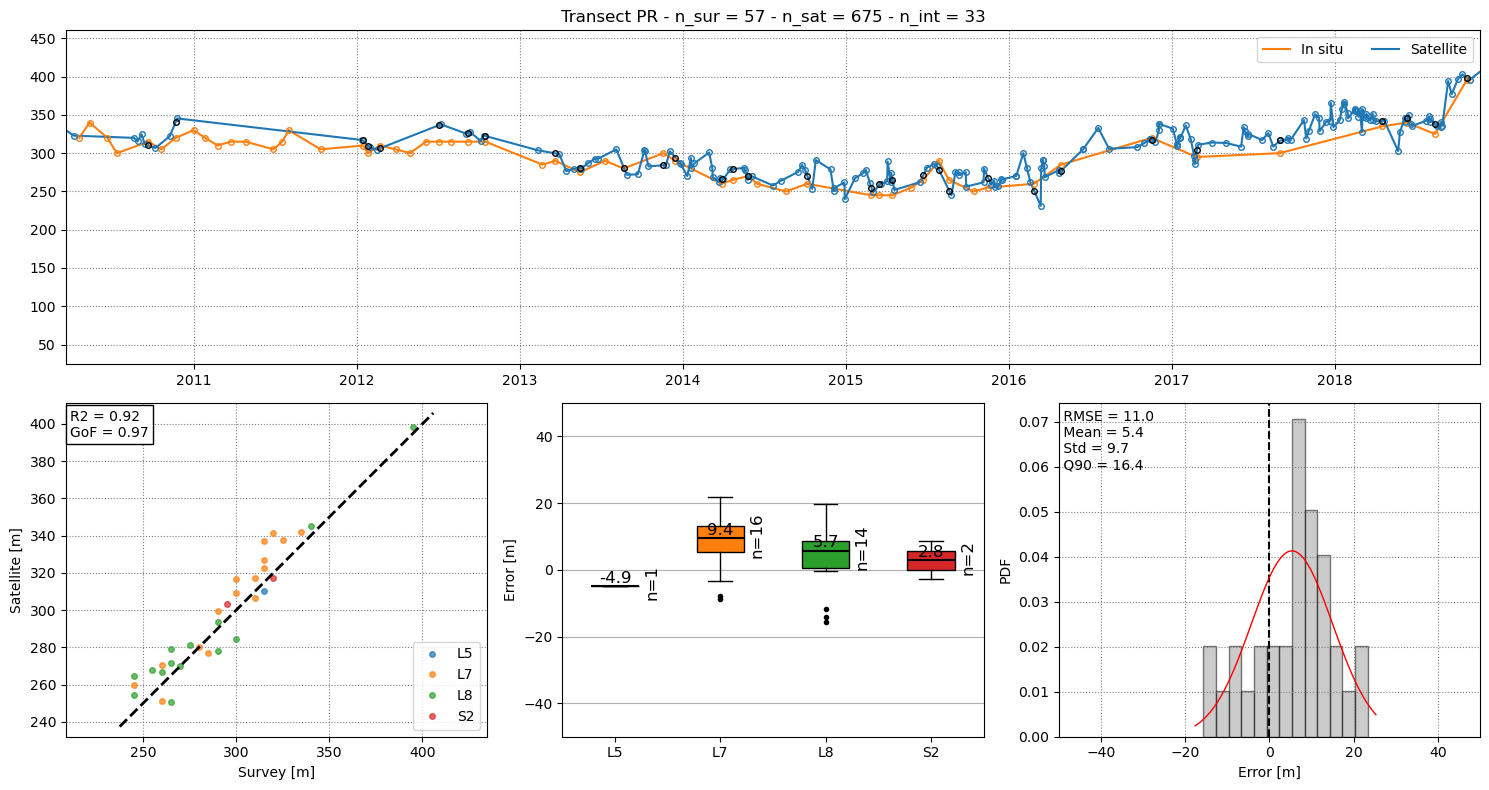

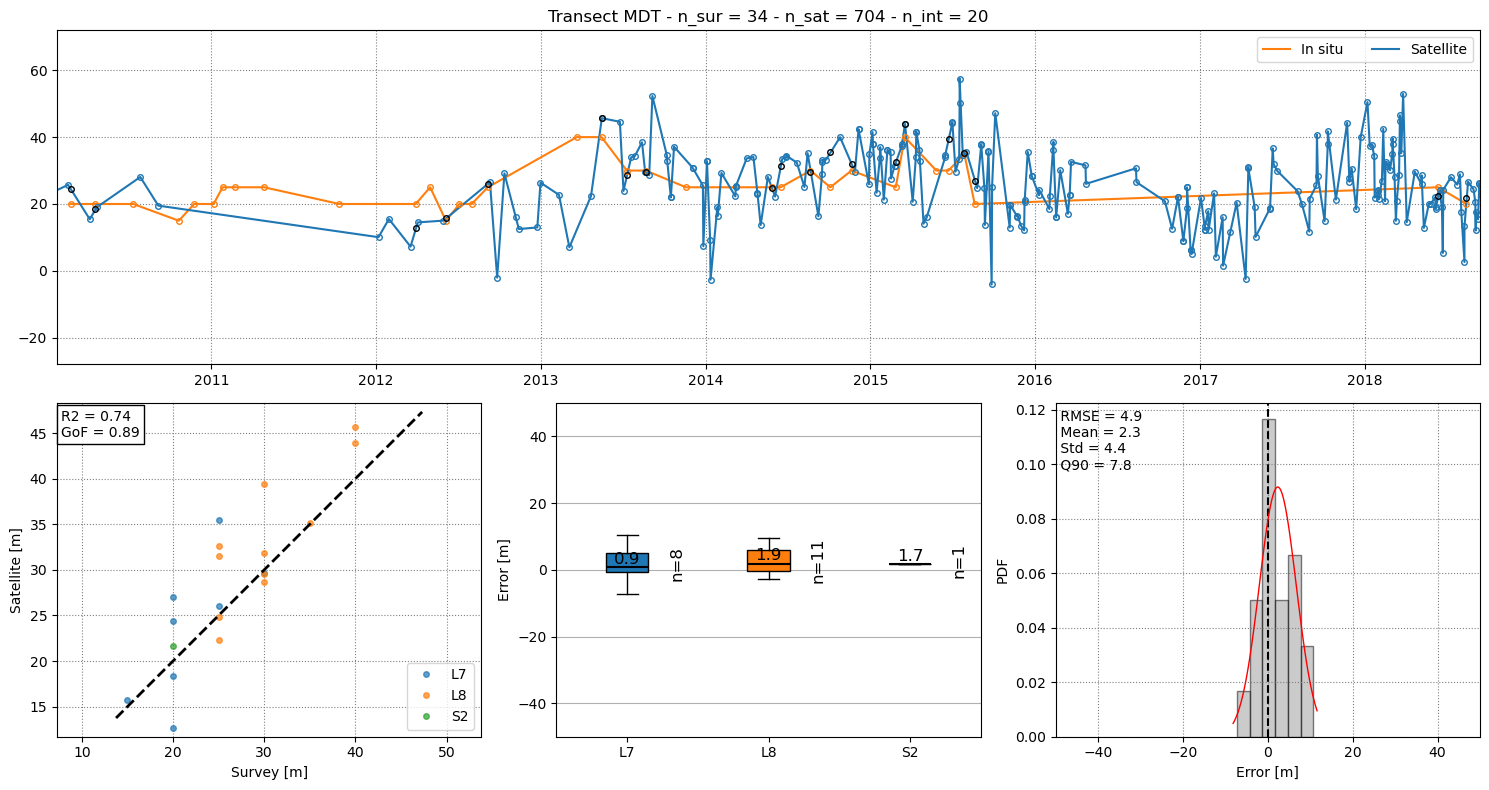

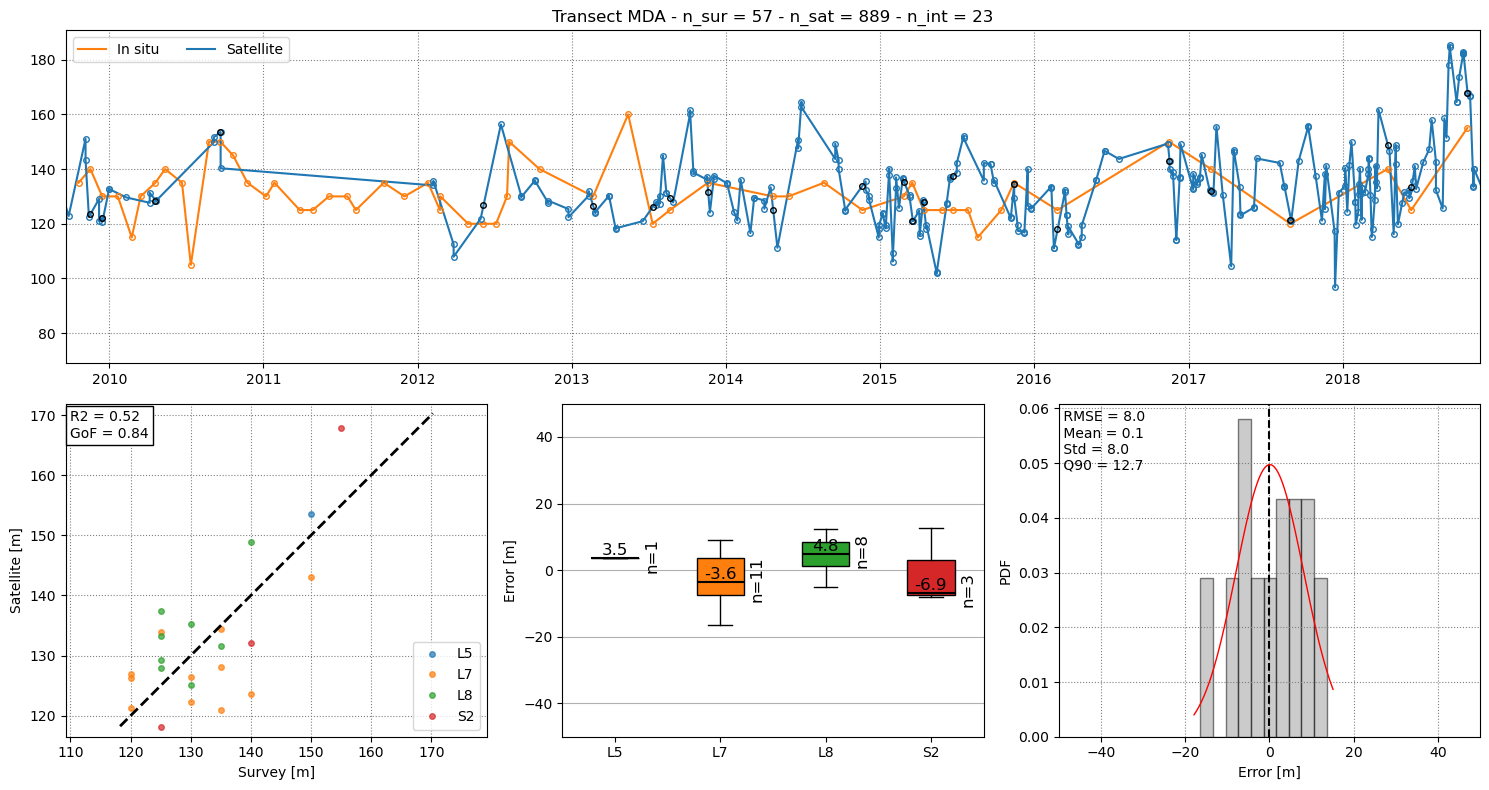

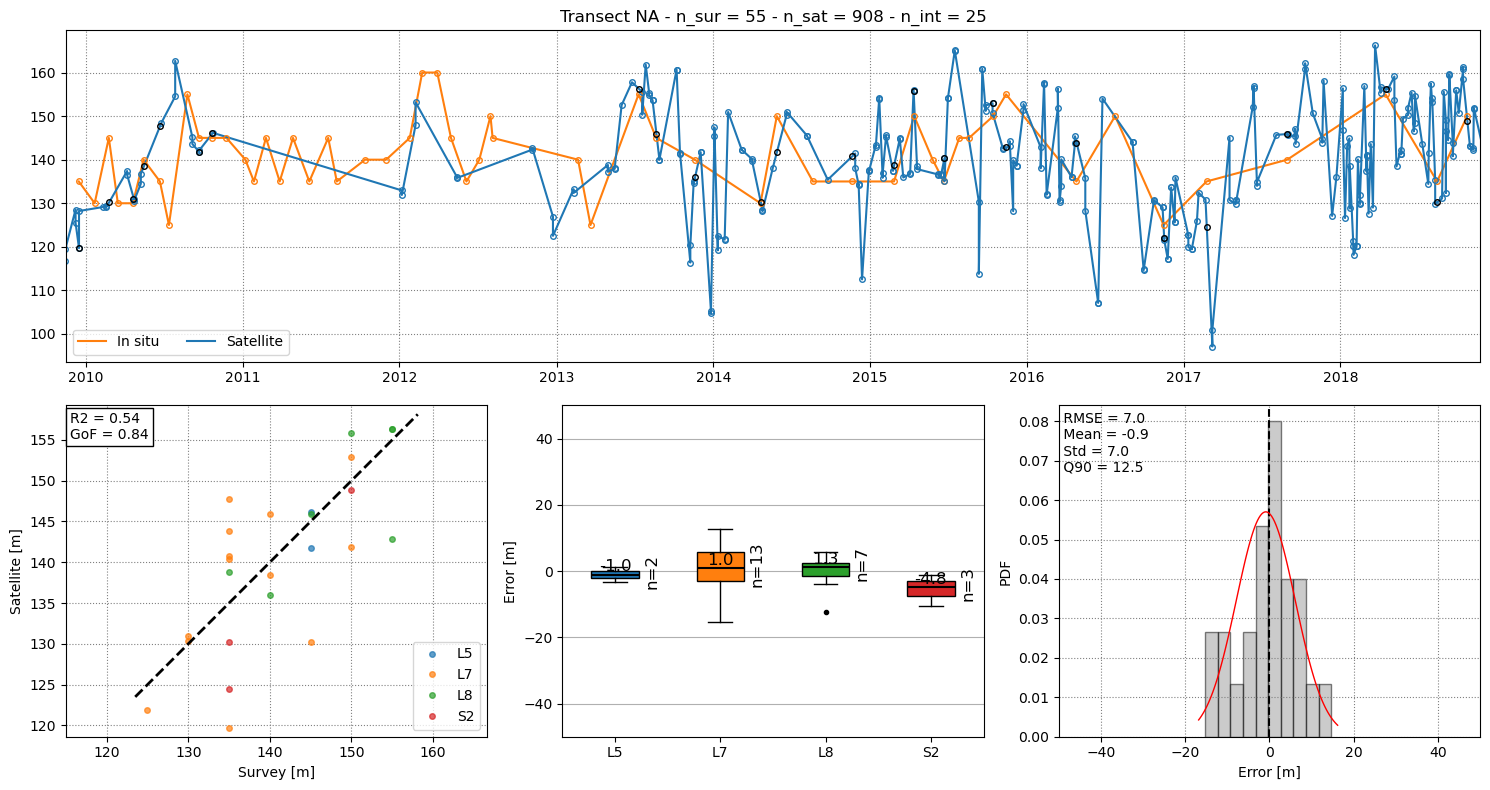

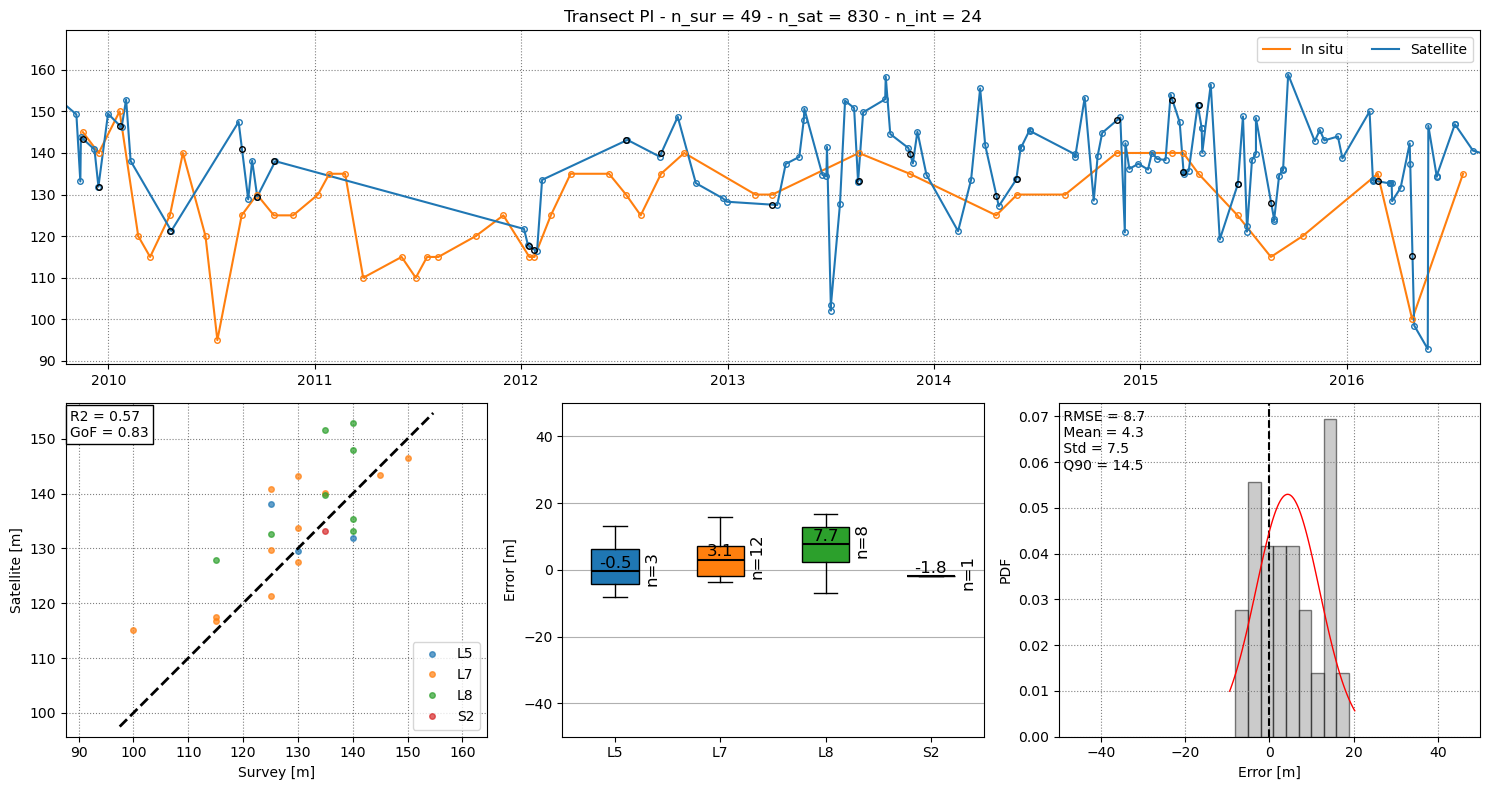

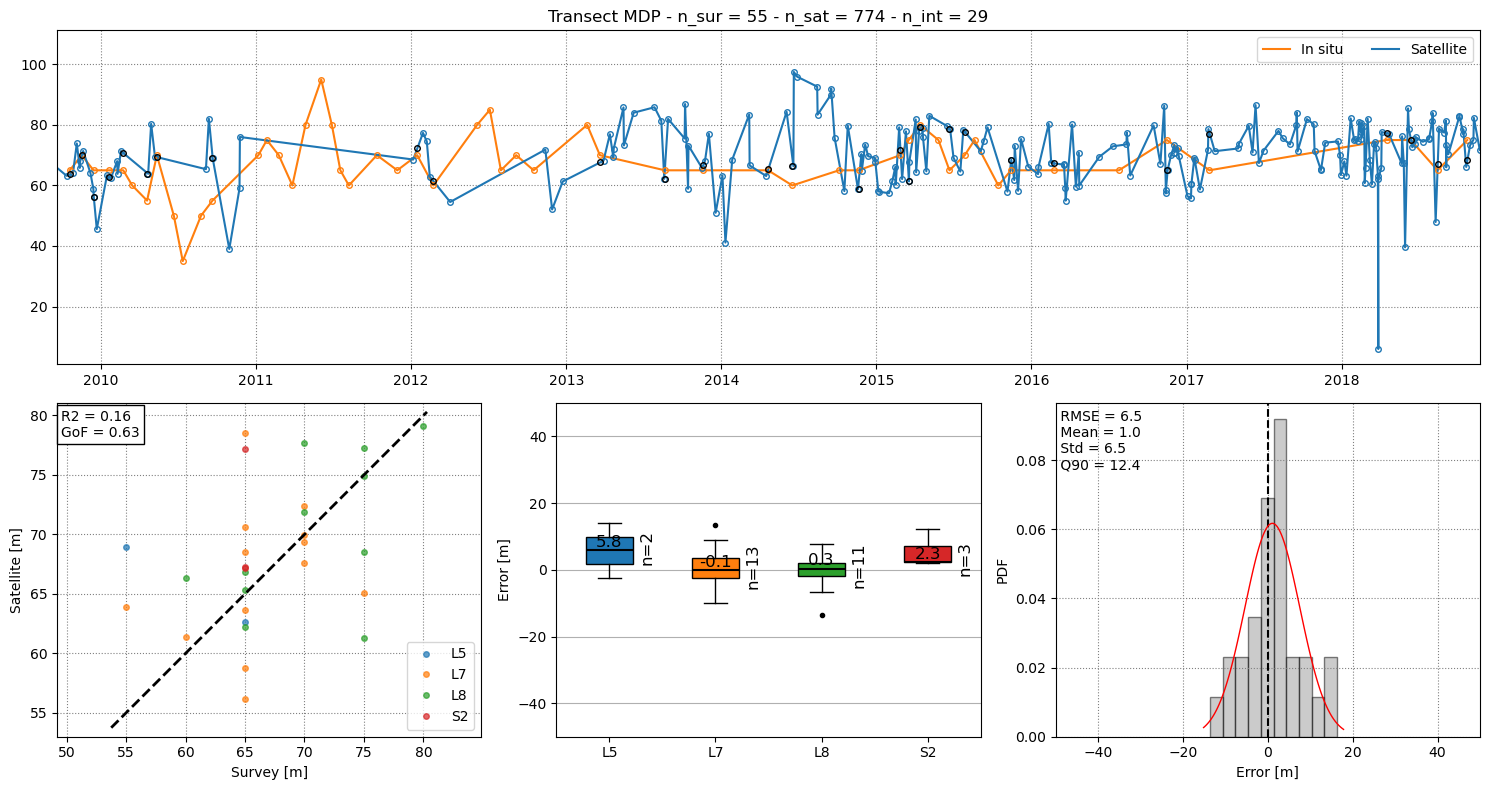

In [6]:
keys= ['PR', 'MDT', 'MDA', 'NA', 'PI', 'MDP']

results,stats_dict  = compare_timeseries2(dates_sat1, dates_in_situ, msas, in_situ, keys, settings, satname_all)

# Iterar sobre los resultados para mostrar o procesar cada figura
chain_dict = {}

for key, result in results.items():
    # Guarda 'chain_sat' y 'chain_sur' para cada key
    chain_dict[key] = {
        'chain_sat': result['chain_sat'],
        'chain_sur': result['chain_sur'],
        'dates_int': result['dates_int'],
        'dates_sur': result['dates_sur']
    }
    satnames = result['satnames']
    fig = result['fig']
    # Guardar la figura con un nombre específico que incluya la clave
    fig.savefig(os.path.join(dir_output,f'{key}_compare_msas.png'))
    # Mostrar la figura o realizar otras operaciones con los resultados
    plt.show(fig)

df_stats_msas = pd.DataFrame(stats_dict).T
df_stats_msas.to_csv(os.path.join(dir_output,'stats assessment msas.csv'))

In [7]:
#Assesment with MSAS + Wave setup
results,stats_dict  = compare_timeseries(dates_sat1, dates_in_situ, msas_waves, in_situ, keys, settings, satname_all)

# Iterar sobre los resultados para mostrar o procesar cada figura
for key, result in results.items():
    chain_sat = result['chain_sat']
    chain_sur = result['chain_sur']
    satnames = result['satnames']
df_stats_msas_wave = pd.DataFrame(stats_dict).T
df_stats_msas_wave.to_csv(os.path.join(dir_output,'stats assessment msas and wave setup.csv'))

# Assesment with FES2022 tidal correction

In [8]:
results,stats_dict  = compare_timeseries(dates_sat1, dates_in_situ, fes2, in_situ, keys, settings, satname_all)

# Iterar sobre los resultados para mostrar o procesar cada figura
for key, result in results.items():
    chain_sat = result['chain_sat']
    chain_sur = result['chain_sur']
    satnames = result['satnames']
df_stats_fes = pd.DataFrame(stats_dict).T
df_stats_fes.to_csv(os.path.join(dir_output,'stats assessment fes.csv'))

In [9]:

results,stats_dict  = compare_timeseries(dates_sat1, dates_in_situ, fes_waves2, in_situ, keys, settings, satname_all)

# Iterar sobre los resultados para mostrar o procesar cada figura
for key, result in results.items():
    chain_sat = result['chain_sat']
    chain_sur = result['chain_sur']
    satnames = result['satnames']
df_stats_fes_wave = pd.DataFrame(stats_dict).T
df_stats_fes_wave.to_csv(os.path.join(dir_output,'stats assessment fes and wave setup.csv'))

# Means and Trends

Subsample the satellite and in situ data to the time period in which there are no more than three months without in situ measurements.

In [10]:
settings_slope = {'date_range': [2009, 2015]}
settings_slope['date_range'] = [
    pytz.utc.localize(datetime(settings_slope['date_range'][0], 10, 1)),
    pytz.utc.localize(datetime(settings_slope['date_range'][1], 12, 31))
]

msas_filtered = {}
fes_filtered = {}
dates_sat_filtered = {}


for key in msas.keys():
    dates_dt=dates_sat1[key]
    dates_dt2= pd.to_datetime(dates_in_situ)
    idx_dates = np.logical_and(np.array(dates_dt) > settings_slope['date_range'][0],
                               np.array(dates_dt) < settings_slope['date_range'][1])


    # Filtrar los datos según los índices de fechas
    msas_filtered[key] = msas[key][idx_dates]
    fes_filtered[key] = fes2[key][idx_dates]
    dates_sat_filtered[key] = np.array(dates_sat1[key])[idx_dates].tolist()

In [11]:
# Filter in_situ data to include only entries within the specified date range

# Remove timezone information from settings_slope to make the dates "naive"
settings_slope['date_range'] = [
    settings_slope['date_range'][0].replace(tzinfo=None),
    settings_slope['date_range'][1].replace(tzinfo=None)
]

# Create the in_situ_filtered dictionary using the "naive" dates
in_situ_filtered = {
    key: [
        value for i, value in enumerate(in_situ[key])
        if settings_slope['date_range'][0] <= dates_in_situ[i] <= settings_slope['date_range'][1]
    ]
    for key in in_situ
}




In [12]:
# Obtaining monthly time series from satellite data
utc = pytz.UTC
start_date = utc.localize(datetime(2009, 10, 1, 0, 0))
end_date = utc.localize(datetime(2015, 12, 1, 0, 0))
monthly_dates = pd.date_range(start='2009-10-01', end='2015-12-01', freq='MS')
fes_monthly = {}
msas_monthly = {}
# Calcular series temporales de medias mensuales para los datos 
for key in dates_sat_filtered.keys():
    dates = pd.to_datetime(dates_sat_filtered[key])
    msas_values = msas_filtered[key]
    fes_values = fes_filtered[key]
    msas_monthly_means = calcular_media_mensual(dates, msas_values)
    fes_monthly_means = calcular_media_mensual(dates, fes_values)
    msas_monthly_means = msas_monthly_means.reindex(monthly_dates, fill_value=np.nan)
    fes_monthly_means = fes_monthly_means.reindex(monthly_dates, fill_value=np.nan)
    msas_monthly[key] = msas_monthly_means['value'].tolist()
    fes_monthly[key] = fes_monthly_means['value'].tolist()
    
# Crear un diccionario de fechas mensuales
dates_monthly = monthly_dates.tolist()

In [13]:
# Calculate means
info=pd.DataFrame()
medias= []
std=[]
for key, values in in_situ_filtered.items():
    media = np.nanmean(values) 
    medias.append(media)
    std1 = np.nanstd(values)  
    std.append(std1)

info['media in_situ']=medias
info['std in_situ']=std

medias= []
std=[]
for key, values in msas_filtered.items():
    media = np.nanmean(values) 
    medias.append(media)
    std1 = np.nanstd(values)  
    std.append(std1)

info['media msas']=medias
info['std msas']=std

medias= []
std=[]
for key, values in fes_filtered.items():
    media = np.nanmean(values)
    medias.append(media)
    std1 = np.nanstd(values)
    std.append(std1)

info['media fes']=medias
info['std fes']=std


info=info.round(0)
info.index=['PR', 'MDT', 'MDA',  'NA','PI', 'MDP']

In [14]:
# Compute trends
tendencias_data = {}

# Iterar sobre los índices de df_means (que corresponden a las claves de tus datos)
for key in msas_monthly.keys():
    tendencias_data[key] = {}

    # Computing trend and its significance for  msas and fes 
    series_msas = msas_monthly[key]
    slope, trend, h, p_value = calcular_tendencia_significancia(series_msas,0.01)
    tendencias_data[key]['slope_msas'] = slope.round(1)
    tendencias_data[key]['trend_msas'] = trend

    series_fes = fes_monthly[key]
    slope, trend, h, p_value = calcular_tendencia_significancia(series_fes,0.01)
    tendencias_data[key]['slope_fes'] = slope.round(1)
    tendencias_data[key]['trend_fes'] = trend

    # Computing trend and its significance for bw in situ
    series_in_situ = in_situ_filtered[key]
    slope, trend, h, p_value = calcular_tendencia_significancia(series_in_situ,0.01)
    tendencias_data[key]['slope_in_situ'] = slope.round(1)
    tendencias_data[key]['trend_in_situ'] = trend

    

# Create DataFrame with results
df_tendencias = pd.DataFrame.from_dict(tendencias_data, orient='index')
info = info.join(df_tendencias)

#Save means and trends
info.to_csv(os.path.join(dir_output,'trend and means.csv'))

# Assessment Slope

In [15]:
#pendientes in situ
dir_slope = os.path.join(base_dir, 'Slopes')
with open(os.path.join(dir_slope,'in_situ_mean_slope.pkl'), 'rb') as f:
    slope_insitu = pickle.load(f)
    slope_insitu=list(slope_insitu.values())
    slope_insitu=np.array(slope_insitu)
    
#pendientes cs.slope

slope_cs1=pd.read_csv(os.path.join(dir_slope,'slope_cs.csv'))
slope_cs=np.array(-slope_cs1['slope'])

Correlation coefficient (r): 0.678
Coefficient of determination (R^2): 0.460
Bias (bias): 0.011
Root mean square error (RMSE): 0.013


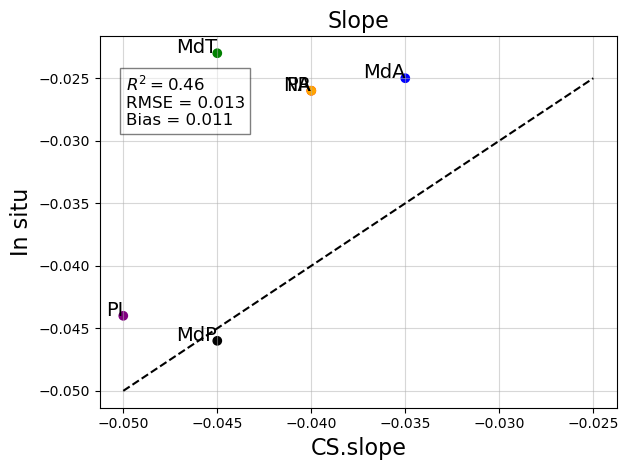

In [16]:
# Define lists of values representing site names
nombre = ['PR', 'MdT', 'MdA', 'NA', 'PI', 'MdP']

# Ensure that both lists have the same length by slicing slope_insitu
slope_insitu = slope_insitu[:len(slope_cs)]  # Adjust in situ slope data to match the length of the coastal slope data

# Perform linear regression to obtain slope, intercept, correlation coefficient, p-value, and standard error
slope, intercept, rvalue, pvalue, std_err = linregress(slope_cs, slope_insitu)

# Calculate the linear regression line based on the slope and intercept
line = slope * slope_cs + intercept

# Calculate the coefficient of determination (R²)
R2 = rvalue**2

# Calculate the bias, which is the mean difference between in situ and coastal slope data
bias = np.mean(slope_insitu - slope_cs)

# Calculate the root mean square error (RMSE) to quantify the differences between predicted and observed values
rmse = np.sqrt(mean_squared_error(slope_insitu, slope_cs))

# Create a scatter plot with the in situ slope data against the coastal slope data
colors = ['red', 'green', 'blue', 'orange', 'purple', 'k']  # Define colors for each point in the scatter plot

plt.scatter(slope_cs, slope_insitu, c=colors, label='Data')  # Plot the data points

# Add labels to each point using their respective site names
for i, name in enumerate(nombre):
    plt.text(slope_cs[i], slope_insitu[i], name, fontsize=14, ha='right', va='baseline')

# Uncomment to plot the regression line
# plt.plot(slope_cs, line, color='black', label='Regression Line')

# Set labels for the axes and the title of the plot
plt.xlabel('CS.slope', fontsize=16)  # Label for the x-axis
plt.ylabel('In situ', fontsize=16)    # Label for the y-axis
plt.title('Slope', fontsize=16)       # Title for the plot

# Add the R², RMSE, and bias values in the upper left corner of the plot
textstr = f'$R^2 = {R2:.2f}$\nRMSE = {rmse:.3f}\nBias = {bias:.3f}'
plt.text(0.05, 0.90, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Define dashed line coordinates for reference
puncteada_x = np.array([-0.050, -0.025])  # X-coordinates for the dashed line
puncteada_y = np.array([-0.050, -0.025])  # Y-coordinates for the dashed line

# Plot the dashed reference line on the scatter plot
plt.plot(puncteada_x, puncteada_y, 'k--')

# Adjust layout for better spacing and appearance
plt.tight_layout()

# Add grid lines to the plot for better readability
plt.grid(alpha=0.5)

# Save the scatter plot as a PNG file with specified DPI
plt.savefig(os.path.join(dir_output, 'assessment_pendientes.png'), dpi=300)

# Print the results of the regression analysis to the console
print(f"Correlation coefficient (r): {rvalue:.3f}")  # Display correlation coefficient
print(f"Coefficient of determination (R^2): {R2:.3f}")  # Display R²
print(f"Bias (bias): {bias:.3f}")  # Display bias
print(f"Root mean square error (RMSE): {rmse:.3f}")  # Display RMSE


In [17]:
# without MDT site
nombre = ['PR', 'MdA', 'NA', 'PI', 'MdP']

slope_cs=np.array([-0.04 , -0.035, -0.04 , -0.05 , -0.045])
slope_insitu=np.array([-0.025,  -0.025, -0.025, -0.045, -0.045])

slope, intercept, rvalue, pvalue, std_err = linregress(slope_cs, slope_insitu)
line = slope * slope_cs + intercept
R2 = rvalue**2
bias = np.mean(slope_insitu - slope_cs)
rmse = np.sqrt(mean_squared_error(slope_insitu, slope_cs))

print(f"Coeficiente de correlación (r): {rvalue:.3f}")
print(f"Coeficiente de determinación (R^2): {R2:.3f}")
print(f"Sesgo (bias): {bias:.3f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.3f}")


Coeficiente de correlación (r): 0.881
Coeficiente de determinación (R^2): 0.776
Sesgo (bias): 0.009
Raíz del error cuadrático medio (RMSE): 0.011
